# MOLE DETECTION  -- Class --

#### Import Necessary Libraries

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [86]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}
labels = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)',
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [87]:

data = pd.read_csv('data/HAM10000_metadata.csv')

SIZE=32

labele = LabelEncoder()
labele.fit(data['dx'])
data['label'] = labele.transform(data["dx"]) 

print(list(labele.classes_))



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [89]:
y=data['label']

class_weights = dict(zip(np.unique(y), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y), 
                y=y))) 

class_weights


{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [105]:
#resampling
n_samples=500


from sklearn.utils import resample
print(data['label'].value_counts())

#Balancing the data
# try this part with image processing



df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]
df_2 = data[data['label'] == 2]
df_3 = data[data['label'] == 3]
df_4 = data[data['label'] == 4]
df_5 = data[data['label'] == 5]
df_6 = data[data['label'] == 6]


df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(data_balanced['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [106]:
data=data_balanced

In [107]:
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"

In [108]:
#Use the path to read images.
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))




In [109]:
data.shape

(3500, 10)

In [110]:
#Convert dataframe column of images into numpy array
X = np.asarray(data['image'].tolist())
X = X/255.  # Scale values to 0-1. 
Y=data['label']  #
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical 


x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

#model.

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 6, 6, 128)        

In [112]:

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                            
batch_size = 16 
epochs = 50

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history = model.fit(x_train, y_train, validation_split=0.2, batch_size = batch_size,  epochs = epochs,callbacks = [learning_rate, early_stop])
#class_weight=class_weights,


Epoch 1/50
140/140 [==============================] - 2s 12ms/step - loss: 0.6785 - acc: 0.7446 - val_loss: 0.8613 - val_acc: 0.7036 - lr: 1.0000e-05
Epoch 2/50
140/140 [==============================] - 2s 12ms/step - loss: 0.6678 - acc: 0.7451 - val_loss: 0.8604 - val_acc: 0.7000 - lr: 1.0000e-05
Epoch 3/50
140/140 [==============================] - 2s 11ms/step - loss: 0.6690 - acc: 0.7384 - val_loss: 0.8585 - val_acc: 0.7018 - lr: 1.0000e-05
Epoch 4/50
140/140 [==============================] - 2s 11ms/step - loss: 0.6706 - acc: 0.7496 - val_loss: 0.8584 - val_acc: 0.7018 - lr: 1.0000e-05
Epoch 5/50
140/140 [==============================] - 2s 12ms/step - loss: 0.6681 - acc: 0.7509 - val_loss: 0.8556 - val_acc: 0.7000 - lr: 1.0000e-05
Epoch 6/50
140/140 [==============================] - 2s 11ms/step - loss: 0.6750 - acc: 0.7393 - val_loss: 0.8546 - val_acc: 0.7000 - lr: 1.0000e-05
Epoch 7/50
140/140 [==============================] - 2s 11ms/step - loss: 0.6638 - acc: 0.7473 - va

22/22 [==============================] - 0s 10ms/step - loss: 0.8605 - acc: 0.6957
Test accuracy: 0.6957142949104309


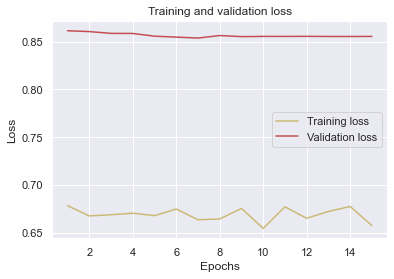

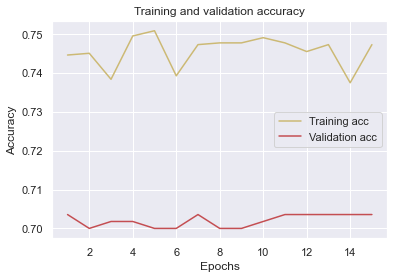

In [113]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [114]:
# Prediction on test data
y_pred = model.predict(x_test)


# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)



22/22 [==============================] - 0s 5ms/step


[[76  9 22 12  5  1  1]
 [11 60 17 10  3  3  1]
 [10  7 58  1 11  8  0]
 [ 1  7  1 89  3  0  0]
 [ 5  1 18  0 53  8  2]
 [ 5  4  6  2 16 55  1]
 [ 0  0  0  1  0  0 96]]


<AxesSubplot:>

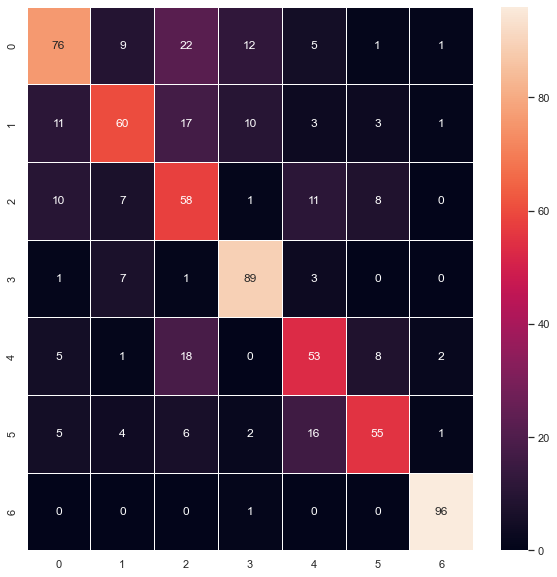

In [115]:
print(cm)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)




Text(0, 0.5, 'Fraction of incorrect predictions')

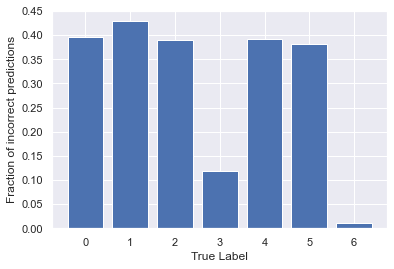

In [116]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [74]:
model_json = model.to_json()
with open("modelmk.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelmk.h5")

----------

#### Define default variables

In [ ]:
# import splitfolders
# IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\')
# splitfolders.ratio(IMAGE_DIR,'IMAGES',seed=42, ratio=(0.7,0.2,0.1))

#### Import the data 

In [9]:
train_dataset= tf.keras.utils.image_dataset_from_directory(
    'IMAGES/train/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
   
)


val_dataset= keras.utils.image_dataset_from_directory(
    'IMAGES/val/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
test_dataset= keras.utils.image_dataset_from_directory(
    'IMAGES/test/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 7007 files belonging to 7 classes.
Found 2000 files belonging to 7 classes.
Found 1008 files belonging to 7 classes.


In [10]:
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('images', ['train', 'val'])

    

In [14]:
x_train=x_train/255

In [12]:
clf = ak.ImageClassifier(overwrite=True, max_trials=1)

In [13]:
#clf.fit(train_generator)

clf.fit(x_train, y_train, epochs=25)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
vanilla           |?                 |image_block_1/block_type
True              |?                 |image_block_1/normalize
False             |?                 |image_block_1/augment
3                 |?                 |image_block_1/conv_block_1/kernel_size
1                 |?                 |image_block_1/conv_block_1/num_blocks
2                 |?                 |image_block_1/conv_block_1/num_layers
True              |?                 |image_block_1/conv_block_1/max_pooling
False             |?                 |image_block_1/conv_block_1/separable
0.25              |?                 |image_block_1/conv_block_1/dropout
32                |?                 |image_block_1/conv_block_1/filters_0_0
64                |?                 |image_block_1/conv_block_1/filters_0_1
flatten           |?                 |classification_head_1/spatial_reduction_1/reduction_type
0.5               |?            

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/model/conv2d_1/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\traitlets\config\application.py", line 965, in launch_instance
      app.start()
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bakig\AppData\Local\Temp\ipykernel_12544\3143019097.py", line 3, in <cell line: 3>
      clf.fit(x_train, y_train, epochs=25)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\tasks\image.py", line 165, in fit
      history = super().fit(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\auto_model.py", line 292, in fit
      history = self.tuner.search(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\engine\tuner.py", line 193, in search
      super().search(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras_tuner\engine\base_tuner.py", line 179, in search
      results = self.run_trial(trial, *fit_args, **fit_kwargs)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras_tuner\engine\tuner.py", line 294, in run_trial
      obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\engine\tuner.py", line 101, in _build_and_fit_model
      _, history = utils.fit_with_adaptive_batch_size(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\utils\utils.py", line 88, in fit_with_adaptive_batch_size
      history = run_with_adaptive_batch_size(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\utils\utils.py", line 101, in run_with_adaptive_batch_size
      history = func(x=x, validation_data=validation_data, **fit_kwargs)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\autokeras\utils\utils.py", line 89, in <lambda>
      batch_size, lambda **kwargs: model.fit(**kwargs), **fit_kwargs
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\_projects\mole_detection\moleenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/conv2d_1/Conv2D/Conv2DBackpropInput'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 155627536 bytes.
  Profiling failure on CUDNN engine 3: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 29032448 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16982144 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3732963328 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/model/conv2d_1/Conv2D/Conv2DBackpropInput}}]] [Op:__inference_train_function_6982]

In [4]:
image_width, image_height = 28,28

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.2,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
                    'IMAGES/train/',
                    batch_size=128,
                    class_mode='categorical',
                    shuffle=True,
                    target_size=(image_width, image_height)
)     

val_generator = train_datagen.flow_from_directory(
                    'IMAGES/val/',
                    batch_size=128,
                    class_mode='categorical',
                    shuffle=True,
                    target_size=(image_width, image_height)
)


test_generator =  test_datagen.flow_from_directory(
                    'IMAGES/test/',
                    batch_size=128,
                    class_mode='categorical',
                    shuffle=True,
                    target_size=(image_width, image_height)
)

Found 7007 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Found 1008 images belonging to 7 classes.


In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,mode='auto')
learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

In [7]:
clf.fit(train_generator)

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

In [ ]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (YPIXEL, XPIXEL, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # 
    input_shape=(299, 299, 3),
    include_top=False)  # 
base_model.trainable = False


# inputs = tf.keras.Input(shape=(299, 299, 3))

# x = base_model(inputs, training=True)

# x = tf.keras.layers.GlobalAveragePooling2D()(x)

# outputs = tf.keras.layers.Dense(7,activation='softmax')(x)
# model = tf.keras.Model(inputs, outputs)


In [ ]:
model=create_model()

In [ ]:
#model = tf.keras.applications.Xception(weights=None, input_shape=(120, 90, 3), classes=7)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
history2 = model.fit(train_generator,validation_data=val_generator, batch_size = 48, epochs = 50,callbacks = [learning_rate, early_stop])

In [ ]:
history2.model.evaluate(test_generator)


In [ ]:
# load and iterate training dataset
train_it = tf.keras.utils.image_dataset_from_directory('images/train/', batch_size=64,image_size=(XPIXEL,YPIXEL))
train_it = train_it.map(process)


# load and iterate validation dataset
val_it = tf.keras.utils.image_dataset_from_directory('images/val/',  batch_size=64,image_size=(XPIXEL,YPIXEL))
val_it = val_it.map(process)
# load and iterate test dataset
test_it = tf.keras.utils.image_dataset_from_directory('images/test/',batch_size=64,image_size=(XPIXEL,YPIXEL))
test_it = test_it.map(process)

In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False



inputs = tf.keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(7,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)



In [ ]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (YPIXEL, XPIXEL, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
#model = tf.keras.applications.Xception(weights=None, input_shape=(120, 90, 3), classes=7)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])



history2 = model.fit(train_it,validation_data=val_it, batch_size = 48, epochs = 50,callbacks = [learning_rate, early_stop])





In [ ]:
history2.model.evaluate(test_it)


### Load data with datagen  - no need for now 

###  optional test later directly put images to datasets

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'images/train',
  
  seed=123,
  image_size=(YPIXEL,XPIXEL),
  batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'images/val',
  
  seed=123,
  image_size=(YPIXEL,XPIXEL),
  batch_size=64)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'images/test',
  
  seed=123,
  image_size=(YPIXEL,XPIXEL),
  batch_size=64)


In [ ]:
model=create_model()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                            

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history2 = model.fit(train_it,validation_data=val_it, batch_size = 24, epochs = 50,callbacks = [learning_rate, early_stop])


#

In [ ]:
history2.model.evaluate(test_it)

In [ ]:
test_it. donttestit fuck_it

In [ ]:
y = np.concatenate([y for x, y in test_it], axis=0)


In [ ]:
y_pred = model.predict(test_it)

In [ ]:
y_pred[0]

In [ ]:
for element in test_it.as_numpy_iterator(): 
  print(element) 


In [ ]:

predicted_categories = tf.argmax(y_pred, axis=1)
#true_categories = tf.concat([y for x, y in test_it], axis=0)
# confusion_matrix(predicted_categories, true_categories)


matrix = confusion_matrix(y, y_pred.argmax(axis=1))
matrix


In [ ]:
true_categories

In [ ]:
y_pred[20]

In [ ]:
true_categories[20]

In [ ]:
q=y_pred[0]

In [ ]:
q=q*100
q

In [ ]:
predicted_categories 
true_categories

In [ ]:

model.evaluate(test_ds)

In [ ]:

predictions = model.predict(test_ds)
labels = test_ds
 
# Printing the input tensor
print('labels: ',labels)
print('Predictions: ',predictions)
 
# Evaluating confusion matrix
res = tf.math.confusion_matrix(labels,predictions)
 
# Printing the result
print('Confusion_matrix: ',res)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                            

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history = model.fit(train_it,validation_data=val_it, batch_size = 24, epochs = 50,callbacks = [learning_rate, early_stop])


#

#### Loss and accuracy curves for training and val sets

In [ ]:
g, ax = plt.subplots(2,1)
ax[0].plot(history2.history['loss'], color='g', label="Training loss")
ax[0].plot(history2.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
loss = model.evaluate(test_it)

In [ ]:
def test_model(model:Sequential, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred=np.round(y_pred,0)
    #y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    cm=confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,label_mapping,"44")
    print(cm)

    plt.show() 

In [ ]:
y_true = test_it.classes

y_pred = model.predict(test_it)

y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
print(clr)
cm=confusion_matrix(y_true, y_pred)
#plot_confusion_matrix(cm,label_mapping,"44")
print(cm)

plt.show() 







In [ ]:

test_it.classes

In [ ]:
def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('_confusion_matrix.png', dpi=300)

### Create train and test datas for original and augumented datasets

In [ ]:
# For Original Dataset
X_train, X_test, Y_train, Y_test = train_test(X, Y)
#Augemented dataset
#X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test(X_aug, Y_aug)
print(X_train.shape)
#print(X_train_aug.shape)



### Create the Model

In [ ]:
model = create_model()

In [ ]:
model_history = train_model(model, X_train, Y_train, 50)

### Saving the model for deployment 

In [ ]:
model_json = model.to_json()
with open("modelbm.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelbm.h5")

### Test Model

In [ ]:
test_model(model, X_test, Y_test)

### Prediction for only one image

In [ ]:
def predict_one_image(image_nr):

    predict_only_one = data.iloc[image_nr]
    print("Imid :" ,predict_only_one.image_id)
    print("Real :" ,predict_only_one.bm)
    
    new_one = predict_only_one.image_pixel.reshape((1,90,120,3))
    preds=model.predict(new_one)[0][0]
    
    max_index_col = np.round(preds,0)

    if preds<0.5:
        preds=1-preds
        

    pred_probabilty = " % {:.2f}".format(preds*100)
    preds=np.round(preds,0)
       
    result=label_mapping.get(max_index_col) + pred_probabilty
    print("Pred :", result)

    sample_data = predict_only_one['image_pixel']
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_data)
    plt.axis("off")
    plt.show() 


In [ ]:
predict_one_image(18)